# Please upvote if you like this kernel for further encouragement


# Background 

E-commerce companies like AMazon , flipkart uses different recommendation systems to provide suggestions to the customers.Amazon uses currently item-item collaberrative filtering, which scales to massive datasets and produces high quality recommendation system in the real time. This system is a kind of a information filtering system which seeks to predict the "rating" or preferences which user is interested in. 

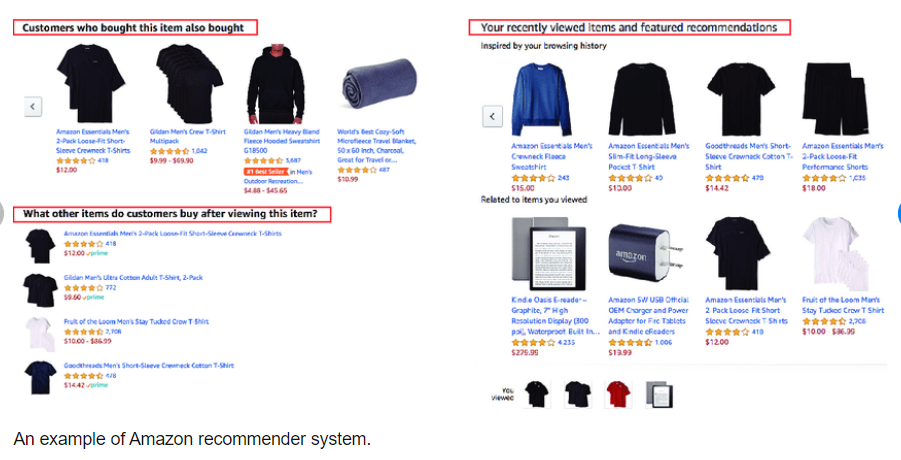



# Introduction to Recommendation systems

In this modern world we are overloaded with data and this data provides us the useful information. But it's not possible for the user to extract the information which interest them from these data. In order to help the user to find out information about the product , recommedation systems where developed. 

Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendations.


What recommeder system can solve ?

1. It can help the user to find the right product.
2. It can increase the user engagement. For example, there's 40% more click on the google news due to recommendation.
3. It helps the item providers to deliver the items to the right user.In Amazon , 35 % products get sold due to recommendation.
4. It helps to make the contents more personalized.In Netflix most of the rented movies are from recommendations.


# Types of recommendations

There are mainly 6 types of the recommendations systems :-

1. Popularity based systems :- It works by recommeding items viewed and purchased by most people and are rated high.It is not a personalized recommendation.
2. Classification model based:- It works by understanding the features of the user and applying the classification algorithm to decide whether the user is     interested or not in the prodcut.
3. Content based recommedations:- It is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.
4. Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types:
 a) User-User 
 b) Item -Item
 
5. Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches . 
6. Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.



# Attribute Information:

● userId : Every user identified with a unique id 

● productId : Every product identified with a unique id 

● Rating : Rating of the corresponding product by the corresponding user 

● timestamp : Time of the rating ( ignore this column for this exercise)



# Import Libraries 

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Load the Dataset and Add headers

In [ ]:
electronics_data=pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])


In [ ]:
# Display the data

electronics_data.head()


In [ ]:

#Shape of the data
electronics_data.shape

In [ ]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [ ]:
#Check the datatypes
electronics_data.dtypes

In [ ]:
electronics_data.info()


In [ ]:
#Five point summary 

electronics_data.describe()['Rating'].T


In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

The rating of the product range from 0 to 1

## Handling Missing values


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())



## Ratings

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

## Unique Users and products


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

## Dropping the TimeStamp Column

In [ ]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [ ]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

In [ ]:
no_of_rated_products_per_user.describe()


In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


# Popularity Based Recommendation

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

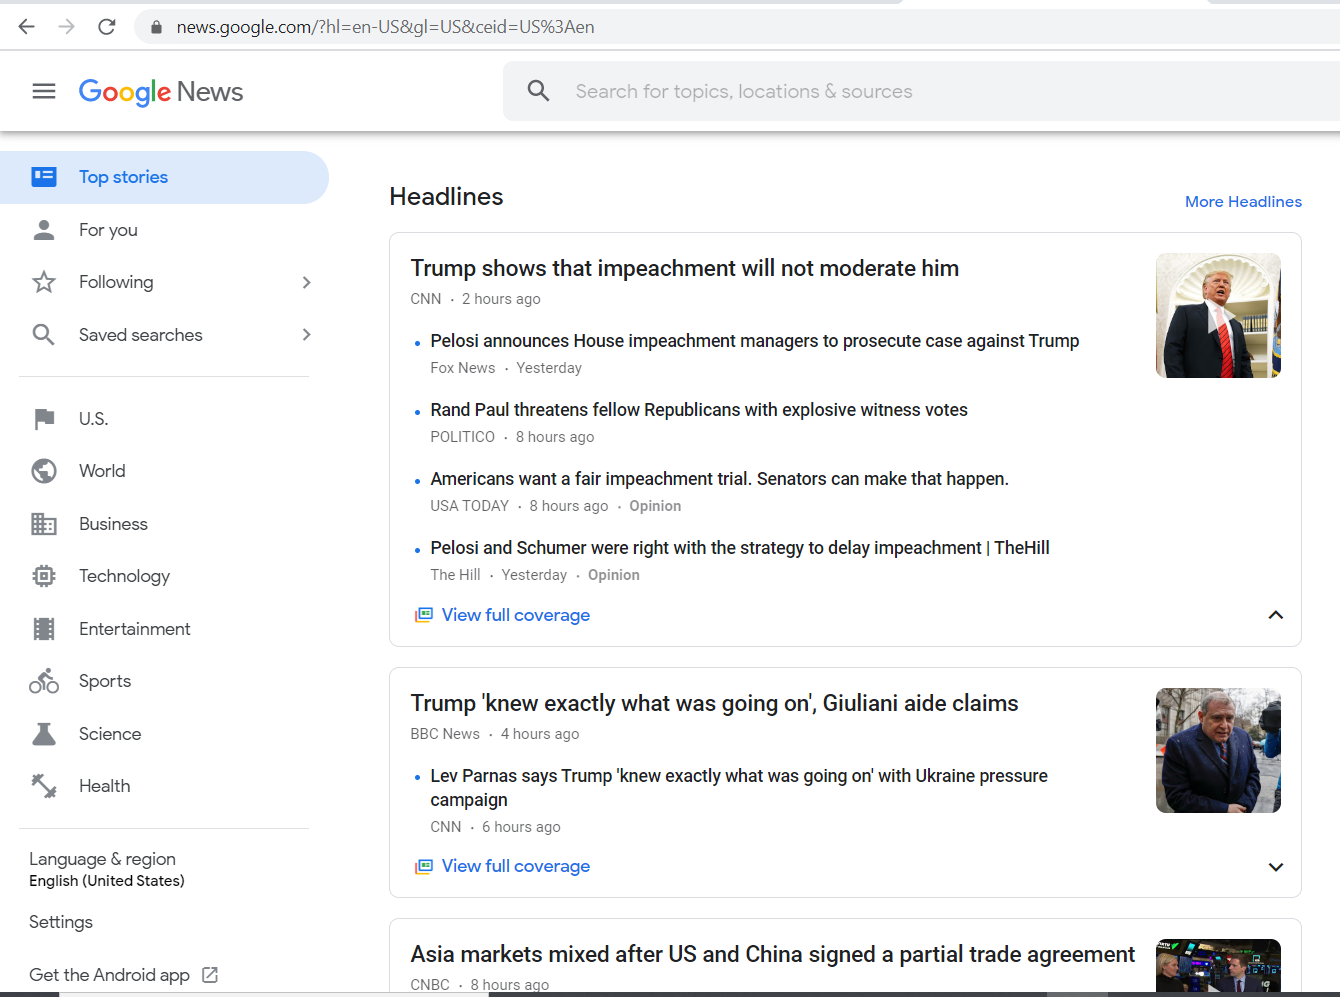

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


In [ ]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


In [ ]:
ratings_mean_count['rating_counts'].max()


In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering (Item-Item recommedation)

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach.
CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.



In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred


In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

# Model-based collaborative filtering system

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [ ]:

new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [ ]:
ratings_matrix.shape


Transposing the matrix

In [ ]:
X = ratings_matrix.T
X.head()

In [ ]:
X.shape


Unique products in subset of data


In [ ]:
X1 = X


In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

In [ ]:
X.index[75]


Index # of product ID purchased by customer



In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

Recommending top 25 highly correlated products in sequence



In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.
